In [1]:
# Import necessary libraries for image processing, numerical computation, deep learning, dataset handling, visualization, and progress tracking.
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader,Subset
from torchvision import datasets, transforms
from tqdm import tqdm
%matplotlib inline

Set a fixed random seed, define separate data transformations for training and testing, load the dataset with respective transforms, split into train/test subsets, and prepare DataLoaders for model input.


In [2]:
torch.manual_seed(42)
# 1️⃣ Define train/test transforms
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# 2️⃣ Load the full dataset twice (different transforms)
full_dataset_train = datasets.ImageFolder(root="PetImages", transform=train_transform)
full_dataset_test = datasets.ImageFolder(root="PetImages", transform=test_transform)

# 3️⃣ Make train/test index split
dataset_size = len(full_dataset_train)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_size = int(0.8 * dataset_size)
train_indices, test_indices = indices[:train_size], indices[train_size:]

# 4️⃣ Create subsets with different transforms
train_dataset = Subset(full_dataset_train, train_indices)
test_dataset = Subset(full_dataset_test, test_indices)

train_loader = DataLoader(train_dataset, 
                        batch_size=64, 
                        shuffle=True)

test_loader = DataLoader(test_dataset, 
                        batch_size=64, 
                        shuffle=True)

inputs, labels = next(iter(train_loader))

📌 __Viewing a Sample Image from the Training Dataset__

This cell demonstrates how to extract and visualize a specific image from the training dataset.
It involves:

Selecting an image by index from the train_dataset.

Printing the image's tensor shape.

Converting the image tensor to a NumPy array with channel-last format.

Displaying the image with its corresponding class label using Matplotlib.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  # Enable inline plotting in Jupyter Notebook

# Retrieve the image tensor and label at index 3 from the training dataset
image_pixels, label = train_dataset[3]
print("Image shape (C x H x W):", image_pixels.shape)

# Rearrange tensor dimensions from (C, H, W) to (H, W, C) for proper visualization
image_pixels_np = image_pixels.permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_pixels_np)
plt.title(f"Label: {train_dataset.dataset.classes[label]}")  # Set title with class label
plt.show()


UsageError: unrecognized arguments: # Enable inline plotting in Jupyter Notebook


📌 __Defining a Simple Convolutional Neural Network (CNN)__
This class defines a basic CNN for binary image classification.
It consists of:

Two convolutional layers for feature extraction.

Max pooling layers to reduce spatial dimensions.

Fully connected layers for classification.

ReLU activations for non-linearity.

python
Copy
Edit


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolution: input channels=3 (RGB), output channels=32, kernel=3x3, padding=1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # Second convolution: input channels=32, output channels=64, kernel=3x3, padding=1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # First fully connected layer: input features=4096 (flattened output), output=128
        self.fc1 = nn.Linear(4096, 128)
        
        # Second fully connected layer: input=128, output=2 (binary classification)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Apply first convolution + ReLU activation
        x = F.relu(self.conv1(x))
        
        # Apply max pooling with 2x2 window
        x = F.max_pool2d(x, 2)
        
        # Apply second convolution + ReLU activation
        x = F.relu(self.conv2(x))
        
        # Apply another max pooling
        x = F.max_pool2d(x, 2)
        
        # Flatten feature maps into a vector
        x = x.view(x.size(0), -1)
        
        # First fully connected layer + ReLU
        x = F.relu(self.fc1(x))
        
        # Output layer (no activation, raw logits)
        x = self.fc2(x)
        
        return x


📌 __Moving the Model and Data to the Appropriate Device__
This cell detects whether a GPU (CUDA) is available and moves both the model and data tensors to the same device for faster computation.

In [ ]:
# Select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the CNN model and move it to the selected device
model = SimpleCNN().to(device)

# Move the input batch and labels to the same device as the model
inputs, labels = inputs.to(device), labels.to(device)


📌 __Defining the Loss Function and Optimizer__
This cell sets up the loss function to measure prediction errors and the optimizer to update model parameters during training.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Use Cross-Entropy Loss for multi-class classification (handles softmax internally)
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with a learning rate of 0.001 to update model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Define split sizes as fractions of the dataset
train_size = 0.60  # 60% of the dataset for training
val_size = 0.40    # 40% of the dataset for validation

# Randomly split the dataset into training and validation sets
# NOTE: random_split expects integer lengths, so these fractions should be multiplied by len(train_dataset)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training set (shuffle=True to randomize batches)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for validation set (shuffle=False to keep order consistent)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


📌 __Training and Validation Loop for CNN__
This cell trains the CNN over multiple epochs while tracking both training and validation losses:

Training Phase – Updates model weights using backpropagation.

Validation Phase – Evaluates model performance on unseen data without updating weights.

Losses are averaged per epoch for better monitoring.

In [ ]:
# Lists to store average training and validation losses per epoch
train_losses = []
val_losses = []

# Number of epochs to train the model
num_epochs = 20

# Loop over epochs
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # ---------------- Training Phase ----------------
    model.train()  # Enable training mode (activates dropout, batch norm updates, etc.)
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="Batch"):
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Reset gradients from previous step
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        outputs = model(images)

        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate training loss
        total_train_loss += loss.item()

    # ---------------- Validation Phase ----------------
    model.eval()  # Set model to evaluation mode (no dropout, no batch norm updates)
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}", unit="Batch"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute validation loss
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

    # Calculate average losses for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # Store losses for visualization later
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Display loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")


📌 __Visualizing Training and Validation Loss__

This cell plots the average training and validation loss per epoch, helping to identify overfitting or underfitting trends in the model’s learning process.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  # Display plots inline in Jupyter Notebook

# Create a range of epoch numbers for the x-axis
epochs = range(1, len(train_losses) + 1)

# Set up the figure size for better readability
plt.figure(figsize=(10, 6))

# Plot training loss over epochs
plt.plot(epochs, train_losses, label='Training Loss', marker='o')

# Plot validation loss over epochs
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Add axis labels and plot title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')

# Add legend to distinguish between training and validation curves
plt.legend()

# Add a grid for better value readability
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
all_true_labels = []
all_pred_probs = []
all_pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        pred_probs = F.softmax(outputs, dim=1)
        all_pred_probs.extend(pred_probs.cpu().numpy())

        pred_labels = torch.argmax(outputs, dim=1)
        all_pred_labels.extend(pred_labels.cpu().numpy())

        # Store true labels
        all_true_labels.extend(labels.cpu().numpy())

# Now make the classification report
from sklearn.metrics import classification_report

report = classification_report(
    all_true_labels,
    all_pred_labels,
    target_names=test_dataset.dataset.classes
)
print(report)



📌 __Model Evaluation on Test Data__
This cell runs the trained CNN on the test dataset to generate predictions, then uses Scikit-learn to produce a classification report showing precision, recall, and F1-score for each class.

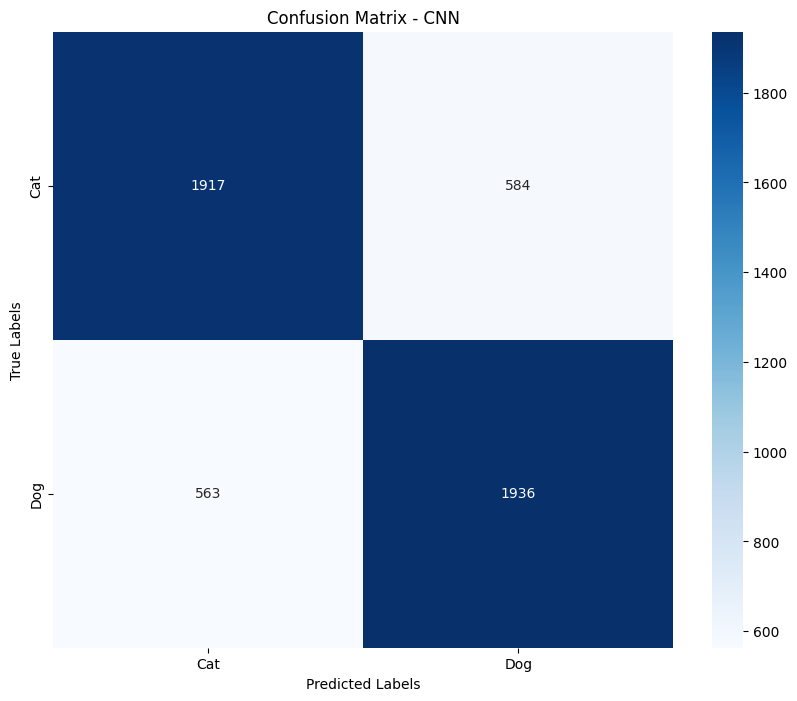

In [ ]:
# Lists to store labels and predictions
all_true_labels = []     # Ground truth labels
all_pred_probs = []      # Prediction probabilities from the model
all_pred_labels = []     # Predicted class labels

# Disable gradient calculation for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move batch to the same device as the model
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass through the model
        outputs = model(images)

        # Apply softmax to get class probabilities
        pred_probs = F.softmax(outputs, dim=1)
        all_pred_probs.extend(pred_probs.cpu().numpy())

        # Get predicted class labels (index of highest probability)
        pred_labels = torch.argmax(outputs, dim=1)
        all_pred_labels.extend(pred_labels.cpu().numpy())

        # Store true labels
        all_true_labels.extend(labels.cpu().numpy())

# ---------------- Classification Report ----------------
from sklearn.metrics import classification_report

# Generate a detailed classification report
report = classification_report(
    all_true_labels,
    all_pred_labels,
    target_names=test_dataset.dataset.classes  # Use class names from dataset
)

# Print the report to console
print(report)


📌 __Making a Prediction on a Single Image__
This cell loads a custom image, applies the same preprocessing as the test dataset, runs it through the trained CNN, and outputs the predicted class along with the probability distribution.

In [ ]:
# Load the image and ensure it is in RGB format
img_path = "cat.jpeg"  # Change this to your own image path
image = Image.open(img_path).convert('RGB')

# Apply the same transformation pipeline used for the test dataset
# unsqueeze(0) adds a batch dimension to match model input requirements
img_tensor = test_transform(image).unsqueeze(0).to(device)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Forward pass to get raw output scores
    output = model(img_tensor)

    # Convert raw scores to probabilities using softmax
    probs = F.softmax(output, dim=1)

    # Get the index of the predicted class (highest probability)
    pred_label_idx = torch.argmax(probs, dim=1).item()

# Map predicted index to actual class name
class_name = test_dataset.dataset.classes[pred_label_idx]

# Display prediction results
print(f"Predicted label: {class_name}")
print(f"Probabilities: {probs.cpu().numpy()}")


Predicted label: Cat
Probabilities: [[0.99408805 0.00591194]]
